# 2D U-Net for Cell Segmentation in Images

### We'll use the [Broad Bioimage Benchmark Collection](https://bbbc.broadinstitute.org/BBBC038) to train a 2D [U-Net](https://arxiv.org/abs/1505.04597) for [segmenting](https://paperswithcode.com/task/semantic-segmentation) cells from images. 

*Approach:*
* Why is U-Net important/different?
* What's the dataset?
* How do I create a TensorFlow dataloader?
* How do I create a TensorFlow model of 2D U-Net
* How do I train the model?
* How do I test the model's performance?

|||||||
|-|-|-|-|-|-|
| ![dataset](https://data.broadinstitute.org/bbbc/BBBC038/BBBC038exampleimage1.png) |  | |  ![dataset2](https://data.broadinstitute.org/bbbc/BBBC038/BBBC038exampleimage2.png) | | ![dataset3](https://data.broadinstitute.org/bbbc/BBBC038/BBBC038exampleimage4.png) |

# There are 2 big ideas in U-Net
1. Skip (residual) connections
2. Encoder/Decoder topology

![skip_connection](skip_connection.png)

Skip connections add a layer in the model to the input of another layer downstream. They mitigate the [vanishing gradient](https://en.wikipedia.org/wiki/Vanishing_gradient_problem) problem with deep networks and seem to smooth the loss curve.

![residual_loss_space](residual_loss_space.png)

[Hao Li, Zheng Xu, Gavin Taylor, Christoph Studer, Tom Goldstein. Visualizing the Loss Landscape of Neural Nets](https://arxiv.org/abs/1712.09913)

# Encoder-Decoders

Transform from one space to another.
Similar to PCA, ICA, Fourier. We find a smaller subspace that can represent the image (lossy).

If the input and output are equal we call it an [Autoencoder](https://en.wikipedia.org/wiki/Autoencoder). Autoencoders are good for compressing data.

U-Net builds on the basic Encoder-Decoder architecture (so not an Autoencoder). An image is the input. It is "encoded" to the bottleneck layer in a latent space. The latent space is "decoded" to provide the mask prediction as output.

![encoder-decoder](encoder-decoder.png)

# 2D U-Net
## Big idea: Combine encoder/decoder with skip connections

In this notebook, we use a 2D U-Net to train a segmentation model that can segment nuclei from images of cells.

[U-Net](https://en.wikipedia.org/wiki/U-Net) is a [fully-convolutional network](https://arxiv.org/abs/1411.4038) created with an encoder-decoder topology. [Ronnenberger et al.](https://arxiv.org/abs/1505.04597) created the topology in 2015 for use in biomedical imaging.

![unet](unet.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tonyreina/unet-broad-nuclei/blob/main/nuclei_segmentation_2d_unet.ipynb)

## Download Broad Dataset
### Broad Bioimage Benchmark Collection
#### Kaggle 2018 Data Science Bowl
https://bbbc.broadinstitute.org/BBBC038

![cc0](http://i.creativecommons.org/p/zero/1.0/88x31.png)
Dataset Copyright: CC0. To the extent possible under law, the various contributors of the imagesets have waived all copyright and related or neighboring rights to BBBC038v1.

"We used image set BBBC038v1, available from the Broad Bioimage Benchmark Collection [Caicedo et al., Nature Methods, 2019]."


This image data set contains a large number of segmented nuclei images and was created for the Kaggle 2018 Data Science Bowl sponsored by Booz Allen Hamilton with cash prizes. The image set was a testing ground for the application of novel and cutting edge approaches in computer vision and machine learning to the segmentation of the nuclei belonging to cells from a breadth of biological contexts.

Images
These images form a diverse collection of biological images collectively containing tens of thousands of nuclei. The variety within the data set reflects the type of images collected by research biologists at universities, bio-techs, and hospitals. The nuclei in the images are derived from a range of organisms including humans, mice, and flies. In addition, nuclei have been treated and imaged in a variety of conditions including fluorescent and histology stains, several magnifications, and varying quality of illumination. Finally, nuclei appear in different contexts and states including cultured mono-layers, tissues, and embryos, and cell division, genotoxic stress, and differentiation. The dataset is designed to challenge an algorithm's ability to generalize across these variations.

In [1]:
import tensorflow as tf
import os

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

%matplotlib inline

In [2]:
# Download the Broad dataset
# Could take a few minutes depending on your internet connection so be patient
zipfilename = "stage1_train.zip"
broad_url = "https://data.broadinstitute.org/bbbc/BBBC038/" + zipfilename
local_dataset_directory = "./broad_data"

try:
    broad = tf.keras.utils.get_file(
        fname=zipfilename,
        origin=broad_url,
        cache_subdir=local_dataset_directory,
        cache_dir=".",
        extract=True,
    )

    print(f"The dataset was extracted to {broad}")

except Exception as inst:

    print("Error in downloading the dataset.")
    print(inst)

The dataset was extracted to ././broad_data/stage1_train.zip


## Create a TensorFlow tf.data Dataloader

Let's try to use some [tf.data](https://www.tensorflow.org/guide/data) methods to glob file patterns.

In the real world we can't load the whole dataset into memory at once. Instead we use a dataloader. This is just the list of files we want to load in during training/inference. At runtime, we load a batch of images/masks at a time (and can perform data augmentation if necessary).

The subfolder `images` contains the image file.
The subfolder `masks` contains the segmented masks of each nucleus. Each mask contains one nucleus. Masks are not allowed to overlap (no pixel belongs to two masks).

In [3]:
# Gets all filename matching pattern
ds_all = tf.data.Dataset.list_files(
    os.path.join(local_dataset_directory, "*/images/*.png")
)

### It's just the list of filenames!

So far our dataloader just contains the filenames. These should be able to fit easily into memory so we are good.

In [4]:
for filename in ds_all.shuffle(50).take(10):
    print(filename)

tf.Tensor(b'./broad_data/7f55678298adb736987d9fb5d1d2daefb08fe5bf4d81b2380bedf9449f79cc38/images/7f55678298adb736987d9fb5d1d2daefb08fe5bf4d81b2380bedf9449f79cc38.png', shape=(), dtype=string)
tf.Tensor(b'./broad_data/57d88f45e479ce3821839b2706d667758c63ac769d76800d815c73d2507c1e42/images/57d88f45e479ce3821839b2706d667758c63ac769d76800d815c73d2507c1e42.png', shape=(), dtype=string)
tf.Tensor(b'./broad_data/2dd9d8c797fc695665326fc8fd0eb5cd292139fa478ccb5acb7fb352f7030063/images/2dd9d8c797fc695665326fc8fd0eb5cd292139fa478ccb5acb7fb352f7030063.png', shape=(), dtype=string)
tf.Tensor(b'./broad_data/5d21acedb3015c1208b31778561f8b1079cca7487399300390c3947f691e3974/images/5d21acedb3015c1208b31778561f8b1079cca7487399300390c3947f691e3974.png', shape=(), dtype=string)
tf.Tensor(b'./broad_data/7ac468eb217b7058d22c1711285d21949b4121bf3fa3217e3e51453666ebecff/images/7ac468eb217b7058d22c1711285d21949b4121bf3fa3217e3e51453666ebecff.png', shape=(), dtype=string)
tf.Tensor(b'./broad_data/1e8408fbb1619e7

### But we need images/masks

Eventually, we need to load the images/masks defined by the filenames. This is the code to do that at runtime.

In [5]:
def process_image(filename):
    """
    Grab the png images
    """

    img_io = tf.io.read_file(filename)
    img = tf.io.decode_png(img_io, channels=3)  # Color

    return img

In [6]:
def process_mask(filename):
    """
    Grab the png masks
    """
    
    mask_io = tf.io.read_file(filename)
    mask = tf.io.decode_png(mask_io, channels=1)  # Grayscale

    return mask

In [7]:
def resize_and_normalize(image, mask, img_height, img_width):
    """
    Resize the images to the same height and width.
    Make sure the images and masks go from 0 to 1
    (rather than 0 to 255). This helps training
    because the initial weights are all close to 0.
    
    """
    
    img_height = 256
    img_width = 256
    pixel_scale_factor = 255   # Normalize images and masks to pixel values (0,1)
    
    # Resize and normalize imaes.
    image = tf.image.resize(image / pixel_scale_factor, [img_height,img_width])
    mask = tf.image.resize(mask / pixel_scale_factor, [img_height,img_width])
    
    return image, mask
    

In [8]:
def process_path(img_filename):
    """
    Start with filenames, load the images/masks, and output them one at a time.
    """

    # Load the raw image from the file as a string
    image = process_image(img_filename)

    # This is just some logic to figure out the name of the associated mask.
    # We know from the dataset that the masks are in the `masks` subdirectory
    # next to the `images` directory.
    # RegEx to replace /images/*.png with /masks
    mask_directory = tf.strings.regex_replace(
        img_filename, "images/(.+).png", "masks/*.png"
    )
    mask_filenames = tf.io.matching_files(mask_directory)
    
    """
    TODO: Can't figure out how to create the tf.zeros with the image shape
    """
    # There's a mask per cell in this dataset.
    # To make things simpler, let's just combine the masks into one mask.
    
    for filename in mask_filenames:
        tmp_mask = process_mask(filename)
        mask = tmp_mask - tmp_mask
        break
    
    for filename in mask_filenames:
        mask += process_mask(filename)

    image, mask = resize_and_normalize(image, mask, img_height=256, img_width=256)
    
    return image, mask

### Maps the processing functions to the TF dataset of filenames

In [9]:
ds = ds_all.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

### Do the train/validation/test split

In [10]:
train_split = 0.80  # 80/20 train split
val_split = 0.50  # 50/50 validation/test split

# Shuffle the dataset before cutting into pieces
ds = ds.shuffle(64)

train_length = int(train_split * len(ds))
train_ds = ds.take(train_length)

# Remaining files will be validation/test dataset
remain_ds = ds.skip(train_length)
val_length = int(val_split * len(remain_ds))
val_ds = remain_ds.take(val_length)
test_ds = remain_ds.skip(val_length)

### Print out some images/masks to sanity check the data loader

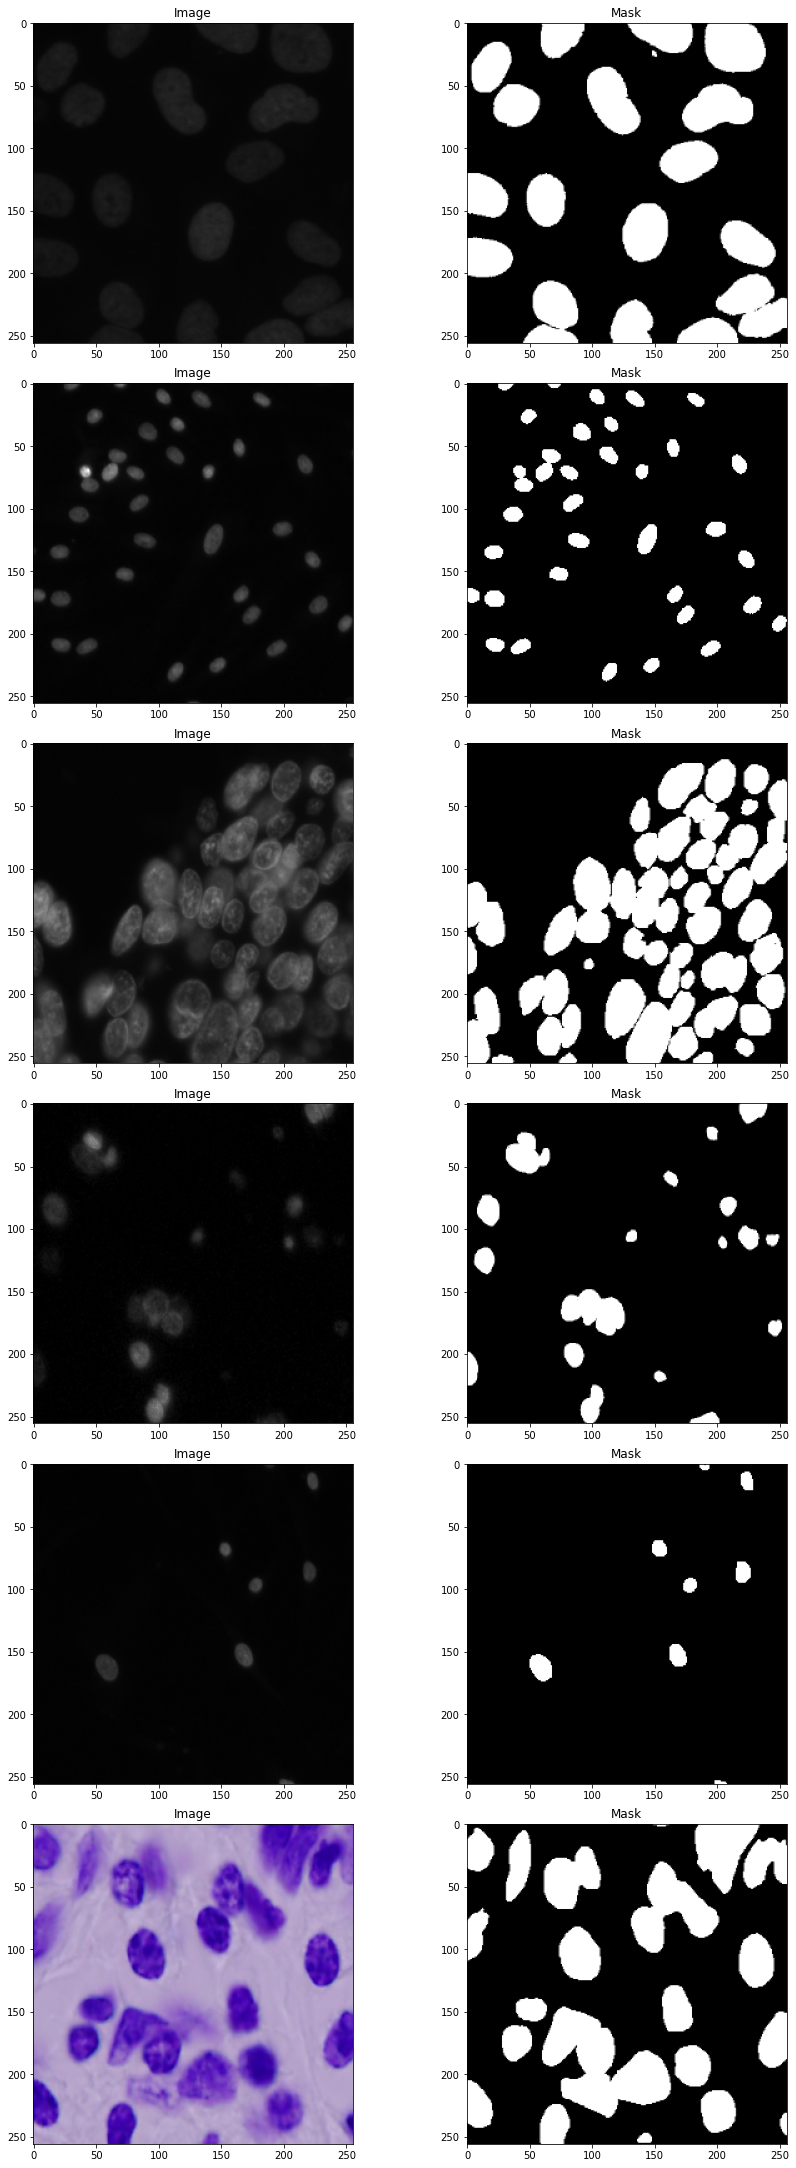

In [11]:
num_examples = 6
idx = 0

fig = plt.figure(figsize=(12, 30), constrained_layout=True)
gs = GridSpec(num_examples, 2, figure=fig)
axs = []

for image, mask in train_ds.shuffle(30).take(num_examples):

    axs.append(fig.add_subplot(gs[idx]))
    axs[-1].imshow(image.numpy())
    # print("Image shape: ", image.numpy().shape)
    plt.title("Image")

    axs.append(fig.add_subplot(gs[idx + 1]))
    axs[-1].imshow(mask.numpy()[:,:,0], cmap="gray")
    plt.title("Mask")

    idx += 2

## Define U-Net 

Define the 2D U-Net model
* Define encoder block
* Define decoder block
* Stack and connect blocks (including skip connections)

In [12]:
def EncoderMiniBlock(
    inputs, n_filters=32, dropout_prob=0.5, max_pooling=True, name="A"
):
    """Building block for encoder"""

    # Two 3x3 convolutions
    conv1 = tf.keras.layers.Conv2D(
        filters=n_filters,
        kernel_size=(3, 3),
        activation="relu",
        padding="same",
        name=f"conv1e_{name}",
    )(inputs)
    conv2 = tf.keras.layers.Conv2D(
        filters=n_filters,
        kernel_size=(3, 3),
        activation="relu",
        padding="same",
        name=f"conv2e_{name}",
    )(conv1)

    # Batch normalization
    bn1 = tf.keras.layers.BatchNormalization(name=f"batchnorm_{name}")(conv2)

    # Dropout (use spatial dropout for convolution)
    # https://www.tensorflow.org/api_docs/python/tf/keras/layers/SpatialDropout2D
    if dropout_prob > 0:
        bn1 = tf.keras.layers.SpatialDropout2D(dropout_prob, name=f"dropout_{name}")(
            bn1
        )

    # Max pooling
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(
            pool_size=(2, 2), name=f"maxpool_{name}"
        )(bn1)
    else:
        next_layer = bn1

    # skip connection (without max pooling)
    skip_connection = bn1

    return next_layer, skip_connection

In [13]:
def DecoderMiniBlock(prev_layer_input, skip_layer_input, n_filters=32, name="A"):
    """Building block for Decoder"""

    # Start with a transpose convolution layer to first increase the size of the image
    up = tf.keras.layers.Conv2DTranspose(
        filters=n_filters,
        kernel_size=(3, 3),
        strides=(2, 2),
        padding="same",
        name=f"up_{name}",
    )(prev_layer_input)

    # Concatenate with skip layer from encoder path
    merge = tf.keras.layers.concatenate(
        [up, skip_layer_input], axis=-1, name=f"concat_{name}"
    )

    # Two 3x3 convolutions
    conv1 = tf.keras.layers.Conv2D(
        filters=n_filters,
        kernel_size=(3, 3),
        activation="relu",
        padding="same",
        name=f"conv1d_{name}",
    )(merge)
    conv2 = tf.keras.layers.Conv2D(
        filters=n_filters,
        kernel_size=(3, 3),
        activation="relu",
        padding="same",
        name=f"conv2d_{name}",
    )(conv1)

    return conv2

In [14]:
def encoder(inputs, n_filters=32):
    """Build the encoder path"""

    # Encoder section
    # 5 encoder mini blocks
    nextlayer, skip_connectionA = EncoderMiniBlock(
        inputs, n_filters, dropout_prob=0, max_pooling=True, name="A"
    )
    nextlayer, skip_connectionB = EncoderMiniBlock(
        nextlayer, n_filters * 2, dropout_prob=0, max_pooling=True, name="B"
    )
    nextlayer, skip_connectionC = EncoderMiniBlock(
        nextlayer, n_filters * 4, dropout_prob=0, max_pooling=True, name="C"
    )
    nextlayer, skip_connectionD = EncoderMiniBlock(
        nextlayer, n_filters * 8, dropout_prob=0.3, max_pooling=True, name="D"
    )
    bottleneck_layer, _ = EncoderMiniBlock(
        nextlayer, n_filters * 16, dropout_prob=0.3, max_pooling=False, name="E"
    )

    return [
        bottleneck_layer,
        skip_connectionA,
        skip_connectionB,
        skip_connectionC,
        skip_connectionD,
    ]

In [15]:
def decoder(bottleneck, skips, n_filters=32, n_classes=1):
    """Build the decoder path"""

    skip_connectionA = skips[0]
    skip_connectionB = skips[1]
    skip_connectionC = skips[2]
    skip_connectionD = skips[3]

    # Decoder section
    # 4 decoder mini blocks
    ublock6 = DecoderMiniBlock(bottleneck, skip_connectionD, n_filters * 8, name="D")
    ublock7 = DecoderMiniBlock(ublock6, skip_connectionC, n_filters * 4, name="C")
    ublock8 = DecoderMiniBlock(ublock7, skip_connectionB, n_filters * 2, name="B")
    ublock9 = DecoderMiniBlock(ublock8, skip_connectionA, n_filters, name="A")

    # 3x3 convolution
    conv9 = tf.keras.layers.Conv2D(
        filters=n_filters, kernel_size=(3, 3), activation="relu", padding="same"
    )(ublock9)

    # If a single class, then sigmoid. If multiple classes, then softmax
    if n_classes == 1:
        activation = "sigmoid"
    else:
        activation = "softmax"

    # 1x1 Convolution to get to the correct number of output filters
    prediction = tf.keras.layers.Conv2D(
        filters=n_classes,
        kernel_size=(1, 1),
        padding="same",
        activation=activation,
        name="prediction",
    )(conv9)

    return prediction

## Define the 2D U-Net model

Here we use the encoder/decoder blocks and hook them together to form U-Net.

In [16]:
def UNet2D(input_size=(None, None, 3), n_filters=32, n_classes=1):
    """
    Combine both encoder and decoder blocks
    Return the model as output
    """
    # Input layer
    inputs = tf.keras.layers.Input(input_size, name="image")

    # Encoder
    output = encoder(inputs, n_filters=n_filters)

    # Decoder
    # Pass in bottleneck and then skip layers
    prediction = decoder(
        output[0], output[1:], n_filters=n_filters, n_classes=n_classes
    )

    # Define the model
    model = tf.keras.models.Model(inputs=[inputs], outputs=[prediction])

    return model

## Create the 2D U-Net model

Use the components we just created to build the 2D U-Net.

In [17]:
n_classes = 1 # Single output mask

unet_model = UNet2D(n_filters=8, n_classes=n_classes)

In [18]:
unet_model.summary(line_length=120)

Model: "model"
________________________________________________________________________________________________________________________
 Layer (type)                          Output Shape               Param #       Connected to                            
 image (InputLayer)                    [(None, None, None, 3)]    0             []                                      
                                                                                                                        
 conv1e_A (Conv2D)                     (None, None, None, 8)      224           ['image[0][0]']                         
                                                                                                                        
 conv2e_A (Conv2D)                     (None, None, None, 8)      584           ['conv1e_A[0][0]']                      
                                                                                                                        
 batchnorm_A (Bat

                                                                                 'batchnorm_B[0][0]']                   
                                                                                                                        
 conv1d_B (Conv2D)                     (None, None, None, 16)     4624          ['concat_B[0][0]']                      
                                                                                                                        
 conv2d_B (Conv2D)                     (None, None, None, 16)     2320          ['conv1d_B[0][0]']                      
                                                                                                                        
 up_A (Conv2DTranspose)                (None, None, None, 8)      1160          ['conv2d_B[0][0]']                      
                                                                                                                        
 concat_A (Concatenate)         

## We can display the model with Netron

## Wow! A custom metric

The Dice coefficient is often used for segmentation tasks. Dice is the amount of overlap between the mask and the prediction. It is the same as F1.

In [19]:
def dice_coef(target, prediction, axis=(1, 2), smooth=0.01):
    """
    Sorenson Dice
    \frac{  2 \times \left | T \right | \cap \left | P \right |}{ \left | T \right | +  \left | P \right |  }
    where T is ground truth mask and P is the prediction mask
    """
    prediction = tf.math.round(prediction)  # Round to 0 or 1

    intersection = tf.reduce_sum(target * prediction, axis=axis)
    union = tf.reduce_sum(target + prediction, axis=axis)
    numerator = tf.constant(2.) * intersection + smooth
    denominator = union + smooth
    coef = tf.reduce_mean(numerator / denominator)

    return coef

## Compile the U-Net model

In [20]:
unet_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="binary_crossentropy" if n_classes==1 else "categorical_crossentropy",
    metrics=["accuracy", dice_coef],
)

## Specify the batch sizes

In [21]:
train_ds = train_ds.batch(16).prefetch(4)
val_ds = val_ds.batch(8).prefetch(4)
test_ds = test_ds.batch(1)

## Callbacks
### TensorBoard and Model Checkpoints

In [22]:
model_path = "unet_2d_model"
tensorboard_path = "logs"
callbacks = [tf.keras.callbacks.ModelCheckpoint(model_path, verbose=1, save_best_only=True),
            tf.keras.callbacks.TensorBoard(tensorboard_path)]

## Train the model

In [23]:
unet_model.fit(train_ds, epochs=20, validation_data=val_ds, callbacks=callbacks)

Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 0.4821 - accuracy: 0.8009 - dice_coef: 0.0924
Epoch 1: val_loss improved from inf to 0.51049, saving model to unet_2d_model
INFO:tensorflow:Assets written to: unet_2d_model/assets
34/34 [==============================] - 109s 3s/step - loss: 0.4821 - accuracy: 0.8009 - dice_coef: 0.0924 - val_loss: 0.5105 - val_accuracy: 0.8611 - val_dice_coef: 1.0981e-04
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 0.2565 - accuracy: 0.8567 - dice_coef: 0.0044
Epoch 2: val_loss improved from 0.51049 to 0.40020, saving model to unet_2d_model
INFO:tensorflow:Assets written to: unet_2d_model/assets
34/34 [==============================] - 112s 3s/step - loss: 0.2565 - accuracy: 0.8567 - dice_coef: 0.0044 - val_loss: 0.4002 - val_accuracy: 0.8606 - val_dice_coef: 7.1521e-04
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.2051 - accuracy: 0.8699 - dice_coef: 0.1398
Epoch 3: val_loss did not impr

In [24]:
%load_ext tensorboard

%tensorboard --logdir logs

## Reload the best saved model

In [25]:
# Reload the best model
# Because we used a custom metric (dice_coef), 
# we either need to pass it into the `load_model` 
# command or just pass `compile=False` (since we are not re-training)
unet_model = tf.keras.models.load_model(model_path, compile=False)

## How did the model perform?

Let's take a few of the hold-out test data to evaluate the model performance.

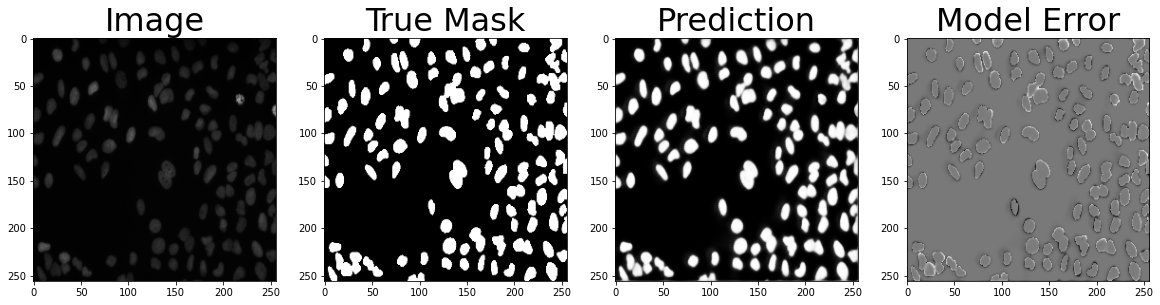

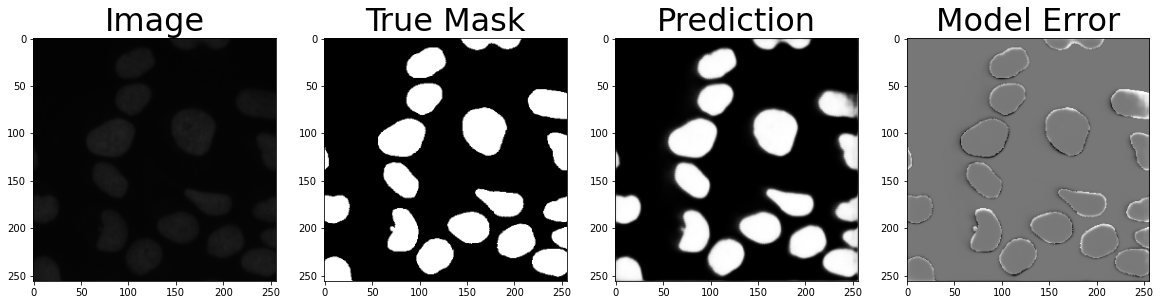

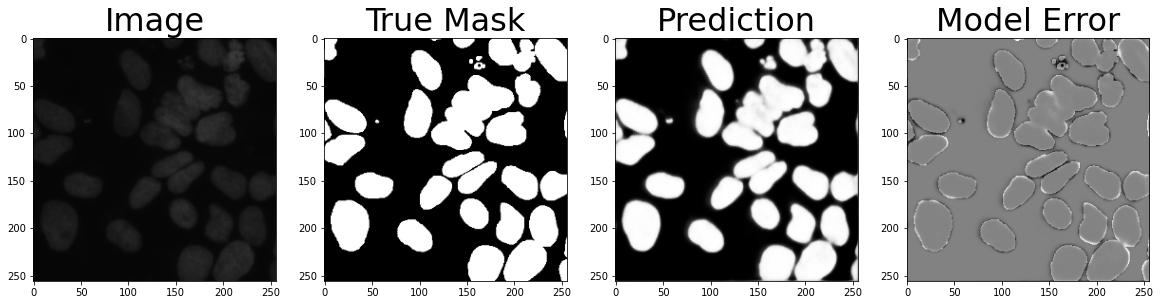

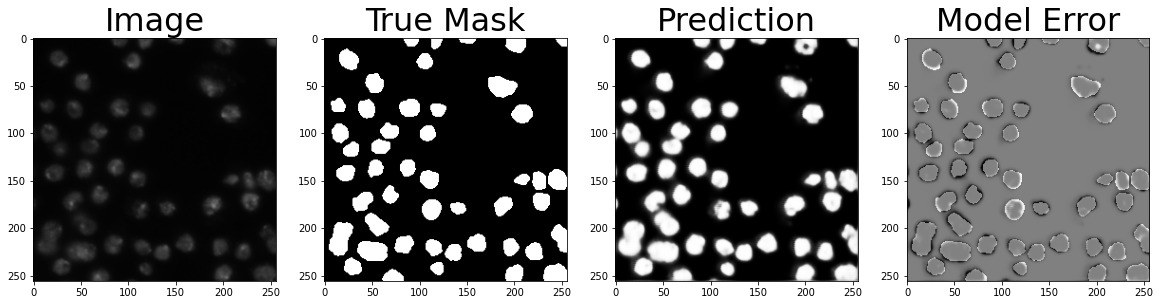

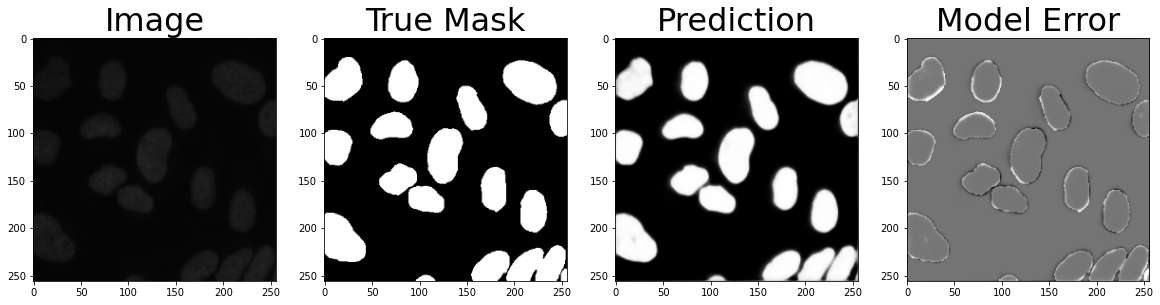

In [26]:
for img, msk in test_ds.take(5):
    
    pred = unet_model.predict(img)
    
    plt.figure(figsize=(20,20))

    plt.subplot(1,4,1)
    plt.imshow(img.numpy()[0])
    plt.title("Image", fontsize=32)

    plt.subplot(1,4,2)
    plt.imshow(msk.numpy()[0,:,:,0], cmap="gray")
    plt.title("True Mask", fontsize=32)

    plt.subplot(1,4,3)
    plt.imshow(pred[0,:,:,0], cmap="gray")
    plt.title("Prediction", fontsize=32)

    plt.subplot(1,4,4)
    plt.imshow(msk.numpy()[0,:,:,0] - pred[0,:,:,0], cmap="gray")
    plt.title("Model Error", fontsize=32)

    plt.show()